In [1]:
%matplotlib inline
import sys
import getpass
import psycopg2
import psycopg2.extras
import numpy
import pandas
from matplotlib import pyplot

In [4]:
# Read scanscore into memory for further processing
passwd = getpass.getpass( 'decat readonly database password: ' )
db = psycopg2.connect(f"dbname='decat' user='decat_ro' password='{passwd}' host='decatdb.lbl.gov'",
                      cursor_factory=psycopg2.extras.RealDictCursor)
q = ( 'SELECT s.id,s.object_id,s.username,s.goodbad,o.rb '
      'FROM scanscore s '
      'INNER JOIN objects o ON s.object_id=o.id '
      'ORDER BY s.object_id' )
cursor = db.cursor()
cursor.execute(q)
scanscore = pandas.DataFrame( cursor.fetchall() )
cursor.close()
db.close()

decat readonly database password:  ············


In [5]:
# Show how many objects each user has vetted
tots = scanscore.groupby(['username','goodbad'])['object_id'].count()
tots = tots.groupby(['username']).agg( num='sum',
                                       good_frac=lambda row: row.loc[:,'good'] / row.sum() )
tots = tots.sort_values("num", ascending=False)
print(tots)


            num  good_frac
username                  
ruby      29792   0.104357
rknop     25938   0.188912
autumn    24760   0.166559
alexis    19600   0.106888
caitlin    3495   0.152217
penugent   2145   0.111422
tkennedy    608   0.238487


In [6]:
# Show stats on how many times a given object has been vetted
print( scanscore.groupby(['object_id'])['username'].count().reset_index(name='#vets')
       .groupby(['#vets'])['object_id'].count().reset_index(name="count") )

   #vets  count
0      1  15725
1      2  17050
2      3  12681
3      4   4008
4      5    454
5      6     28


In [7]:
# Show counts of num goods and num bads.  Not terribly meaningful by itself, we
#   really need to do cross counts
print( scanscore.groupby( ['object_id', 'goodbad'] )['object_id'].count().reset_index(name='num')
       .groupby( ['goodbad', 'num'] )['num'].count().reset_index(name='count') )

   goodbad  num  count
0      bad    1  16942
1      bad    2  15467
2      bad    3   9960
3      bad    4   2952
4      bad    5    302
5      bad    6     20
6     good    1   6300
7     good    2   2681
8     good    3    883
9     good    4    187
10    good    5     17


In [8]:
# Create a table where each row is one object, that has username and goodbad as lists
# This takes a few seconds
objtable = ( scanscore.groupby( ['object_id', 'rb'] )[ ["username", "goodbad"] ]
               .agg( tuple ) )
objtable["ngood"] = objtable["goodbad"].apply( lambda x: ( numpy.array( x ) == "good" ).sum() )
objtable["nbad"] = objtable["goodbad"].apply( lambda x: ( numpy.array( x ) == "bad" ).sum() )
objtable.reset_index(inplace=True)

In [9]:
print(objtable)

       object_id        rb               username          goodbad  ngood  \
0             63  0.000034          (rknop, ruby)       (bad, bad)      0   
1            101  0.000059         (alexis, ruby)       (bad, bad)      0   
2            162  0.000077  (rknop, ruby, alexis)  (bad, bad, bad)      0   
3            258  0.007573  (rknop, ruby, alexis)  (bad, bad, bad)      0   
4            324  0.001230                (ruby,)           (bad,)      0   
...          ...       ...                    ...              ...    ...   
49941   11250920  0.001256              (alexis,)           (bad,)      0   
49942   11251545  0.000476              (alexis,)           (bad,)      0   
49943   11255399  0.002609         (ruby, alexis)       (bad, bad)      0   
49944   11256692  0.007639         (ruby, alexis)      (bad, good)      1   
49945   11258949  0.000983              (alexis,)           (bad,)      0   

       nbad  
0         2  
1         2  
2         3  
3         3  
4    

In [10]:
print( objtable.columns )

Index(['object_id', 'rb', 'username', 'goodbad', 'ngood', 'nbad'], dtype='object')


In [11]:
# Show consistency stats
maxgood = objtable['ngood'].max()
maxbad = objtable['nbad'].max()
print( f'{"nbad":>6s} |', end='' )
for j in range(maxbad+1):
    print( f' {j:5d} |', end='' )
print('\nngood  |', end='')
for j in range(maxbad+1):
    print( '       |', end='')
print('\n-------|', end='')
for j in range(maxbad+1):
    print( '-------|', end='')
print('')
for i in range(maxgood+1):
    print( f' {i:5d} |', end='' )
    for j in range(maxbad+1):
        n = ( ( objtable['ngood'] == i ) & ( objtable['nbad'] == j ) ).sum()
        print( f' {n:5} |', end='' )
    print('\n-------|', end='')
    for j in range(maxbad+1):
        print( '-------|', end='')
    print('')

  nbad |     0 |     1 |     2 |     3 |     4 |     5 |     6 |
ngood  |       |       |       |       |       |       |       |
-------|-------|-------|-------|-------|-------|-------|-------|
     0 |     0 | 13592 | 13573 |  9492 |  2900 |   301 |    20 |
-------|-------|-------|-------|-------|-------|-------|-------|
     1 |  2133 |  2123 |  1557 |   435 |    51 |     1 |     0 |
-------|-------|-------|-------|-------|-------|-------|-------|
     2 |  1354 |   989 |   306 |    31 |     1 |     0 |     0 |
-------|-------|-------|-------|-------|-------|-------|-------|
     3 |   643 |   209 |    29 |     2 |     0 |     0 |     0 |
-------|-------|-------|-------|-------|-------|-------|-------|
     4 |   158 |    27 |     2 |     0 |     0 |     0 |     0 |
-------|-------|-------|-------|-------|-------|-------|-------|
     5 |    15 |     2 |     0 |     0 |     0 |     0 |     0 |
-------|-------|-------|-------|-------|-------|-------|-------|


In [12]:
# A function to add stats for a given user
def adduserstats( objtable, user ):
    if f"{user}_good" in objtable.columns:
        return
    sys.stderr.write( f"Adding isgood/isbad for {user}...\n" )
    def isgoodbad( row, user, goodbad ):
        dex = numpy.where(numpy.array( row["username"], ndmin=1 ) == user)[0]
        if dex.size == 0:
            return False
        else:
            return numpy.array( row["goodbad"], ndmin=1)[dex[0]] == goodbad
    objtable[f"{user}_good"] = objtable.apply( lambda row: isgoodbad(row, user, "good"), axis=1)
    objtable[f"{user}_bad"] = objtable.apply( lambda row: isgoodbad(row, user, "bad"), axis=1)
    sys.stderr.write( f"...done adding isgood/isbad for {user}.\n" )
    sys.stderr.flush()
    
# A function to print user stats
def userstats( objtable, user ):
    adduserstats( objtable, user )
    goodtable = objtable[ objtable[f"{user}_good"] ].groupby( [ f"ngood", f"nbad"] )["username"].count()
    print( f"Ratings for objects that {user} rated good:" )
    print( goodtable )
    badtable = objtable[ objtable[f"{user}_bad"] ].groupby( [f"ngood", f"nbad"] )["username"].count()
    print( f"Ratings for objects that {user} rated bad:" )
    print( badtable )
    
# A function to compare two users
def compareusers( objtable, user1, user2 ):
    adduserstats( objtable, user1 )
    adduserstats( objtable, user2 )
    goodgood = ( objtable[f"{user1}_good"] & objtable[f"{user2}_good"] ).sum()
    goodbad =  ( objtable[f"{user1}_good"] & objtable[f"{user2}_bad"] ).sum()
    badgood =  ( objtable[f"{user1}_bad"] & objtable[f"{user2}_good"] ).sum()
    badbad =   ( objtable[f"{user1}_bad"] & objtable[f"{user2}_bad"] ).sum()
    
    print( f'{user1:>8s} |   good   |    bad   |' )
    print( f'{user2:<8s} |          |          |' )
    print( f'---------------------------------' )
    print( f'good     |   {goodgood:4d}   |   {badgood:4d}   |' )
    print( f'---------------------------------' )
    print( f'bad      |   {goodbad:4d}   |   {badbad:4d}   |' )
    print( f'---------------------------------' )

# Compare user to majority
def uservsmajority( objtable, user, minrates=2, mindiff=2 ):
    adduserstats( objtable, user )
    goodtable = objtable[ ( objtable["ngood"]-objtable["nbad"] >= mindiff ) &
                          ( objtable["ngood"]+objtable["nbad"] >= minrates ) ]
    badtable = objtable[ ( objtable["nbad"]-objtable["ngood"] >= mindiff ) &
                         ( objtable["nbad"]+objtable["ngood"] >= minrates ) ]
    goodgood = ( goodtable[f"{user}_good"] ).sum()
    goodbad = ( goodtable[f"{user}_bad"] ).sum()
    badgood = ( badtable[f"{user}_good"] ).sum()
    badbad = ( badtable[f"{user}_bad"] ).sum()
    
    print( f'{user} vs. majority (diff≥{mindiff}, n.rates≥{minrates})' )
    print( f' majority|   good   |    bad   |' )
    print( f'{user:<8s} |          |          |' )
    print( f'---------------------------------' )
    print( f'good     |   {goodgood:4d}   |   {badgood:4d}   |' )
    print( f'---------------------------------' )
    print( f'bad      |   {goodbad:4d}   |   {badbad:4d}   |' )
    print( f'---------------------------------' )


In [13]:
userstats( objtable, "rknop" )

Adding isgood/isbad for rknop...
...done adding isgood/isbad for rknop.


Ratings for objects that rknop rated good:
ngood  nbad
1      0       283
       1       873
       2       779
       3       194
       4        21
       5         1
2      0       843
       1       713
       2       225
       3        21
       4         1
3      0       543
       1       180
       2        23
       3         2
4      0       154
       1        26
       2         2
5      0        14
       1         2
Name: username, dtype: int64
Ratings for objects that rknop rated bad:
ngood  nbad
0      1       1312
       2       7637
       3       7707
       4       2704
       5        297
       6         20
1      1        400
       2        506
       3        212
       4         28
2      1        121
       2         61
       3          8
3      1         18
       2          6
4      1          1
Name: username, dtype: int64


In [14]:
compareusers( objtable, "rknop", "penugent" )

Adding isgood/isbad for penugent...
...done adding isgood/isbad for penugent.


   rknop |   good   |    bad   |
penugent |          |          |
---------------------------------
good     |    111   |     41   |
---------------------------------
bad      |    167   |   1040   |
---------------------------------


In [15]:
uservsmajority( objtable, "rknop", minrates=1, mindiff=2 )

rknop vs. majority (diff≥2, n.rates≥1)
 majority|   good   |    bad   |
rknop    |          |          |
---------------------------------
good     |   1764   |    217   |
---------------------------------
bad      |     19   |   18605   |
---------------------------------


In [16]:
# Make a histogram of rb scores
def histrb( objtable, mode="unanimous", user=None, minrates=2, mindiff=2, ylog=True, ylinmax=5000 ):
    if mode == "user":
        if user is None:
            raise ValueError( "Must specify user for mode user" )
        adduserstats( objtable, user )
        bads = objtable[ objtable[f"{user}_bad"] ]
        goods = objtable[ objtable[f"{user}_good"] ]
        title = f"{user} rankings"
    elif mode == "unanimous":
        bads = objtable[ ( objtable["ngood"] == 0 ) & ( objtable["nbad"] >= minrates ) ]
        goods = objtable[ ( objtable["ngood"] >= minrates ) & ( objtable["nbad"] == 0 ) ]
        title = f"Unanimous vetting with at least {minrates} rankings"
    elif mode =="majority":
        bads = objtable[ ( objtable["nbad"]-objtable["ngood"] >= mindiff ) &
                         ( objtable["nbad"]+objtable["ngood"] >= minrates ) ]
        goods = objtable[ ( objtable["ngood"]-objtable["nbad"] >= mindiff ) &
                          ( objtable["ngood"]+ objtable["nbad"] >= minrates ) ]
        title = f"Majority vetting w/ ≥{minrates} ratings and difference ≥ {mindiff}"
    else:
        raise ValueError( f"Unknown mode {mode}" )
    goodrb = goods["rb"].values
    badrb = bads["rb"].values
    # Have to do the range to 1.1 because numpy.hist doesn't count the right edge,
    #  and we definitely want to include rb=1.0
    bins = numpy.arange( 0., 1.2, 0.1 )
    goodhist, junk = numpy.histogram( goodrb, bins )
    badhist, junk = numpy.histogram( badrb, bins )
    fig = pyplot.figure( figsize=(10,6), tight_layout=True )
    ax = fig.add_subplot( 1, 1, 1 )
    if ylog:
        ax.set_yscale("log")
    else:
        ax.set_ylim(0, ylinmax)
    ax.set_title( title, fontsize=18 )
    ax.set_xlabel( 'rb', fontsize=18 )
    ax.set_ylabel( 'N', fontsize=18 )
    ax.tick_params( axis='both', labelsize=16 )
    ax.step( bins[:-1], goodhist, color='b', where="post" )
    ax.step( bins[:-1], badhist, color='r', where="post" )
    fig.show()
    return fig

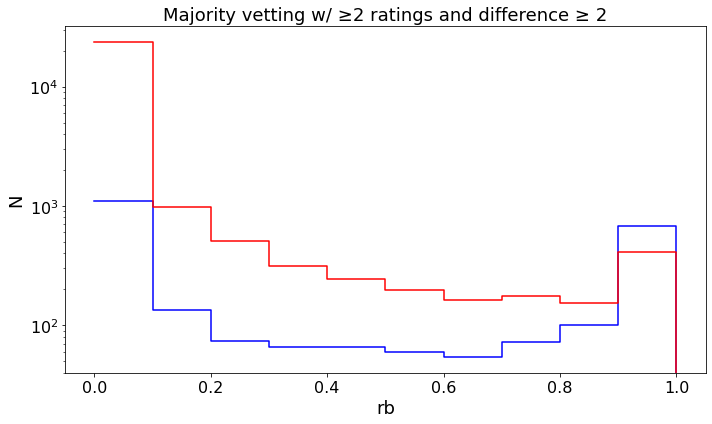

In [21]:
fig = histrb( objtable, mode="majority", user="rknop", minrates=2, mindiff=2, ylog=True, ylinmax=1500 )
fig.savefig( "vettingvsrb.svg" )